# Multi-Layer Perceptron for Text-to-Image Retrieval

This notebook implements a deep learning model that translates text embeddings into image embeddings for cross-modal retrieval tasks. The model learns to map textual descriptions to their corresponding visual representations using a supervised contrastive learning approach.

## Overview
- **Task**: Text-to-Image Retrieval
- **Architecture**: Multi-Layer Perceptron (MLP) with Layer Normalization
- **Framework**: PyTorch Lightning
- **Optimization**: Contrastive Learning with Temperature Scaling

## Configuration Setup

Import required libraries and verify hardware availability.

In [6]:
# !pip install torch torchvision pytorch-lightning numpy pandas matplotlib pillow scikit-learn tqdm rich kaggle

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


In [7]:
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset

print(f"✅ Imports complete")
print(f"   PyTorch version: {torch.__version__}")
print(f"   Lightning version: {pl.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

✅ Imports complete
   PyTorch version: 2.9.0+cu128
   Lightning version: 2.5.6
   CUDA available: True


## Download and Unzip the Dataset

Dataset downloads require authentication. Ensure your kaggle.json credentials file is located in the same directory as this notebook file before running the download script.

In [8]:
import os
import zipfile
import shutil

target_folder = "./data"
zip_filename = "aml-competition.zip"
zip_path = os.path.join(target_folder, zip_filename)

train_folder = os.path.join(target_folder, "train")
test_folder = os.path.join(target_folder, "test")

os.makedirs(target_folder, exist_ok=True)

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print(f"✅ Folders 'train' and 'test' already exist in '{target_folder}'. Skipping everything.")

else:
    if not os.path.exists(zip_path):
        print(f"⬇️ Downloading {zip_filename}...")
        
        os.environ['KAGGLE_CONFIG_DIR'] = '.'
        !chmod 600 ./kaggle.json
        !kaggle competitions download -c aml-competition -p {target_folder}
        
        if os.path.exists(zip_path):
            print("Download complete.")
        else:
            raise FileNotFoundError("❌ Download failed!")
    else:
        print(f"📦 Zip file found at '{zip_path}'.")

    print(f"📂 Extracting {zip_filename}...")
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_folder)
        
        for folder_name in ['train', 'test']:
            outer_folder = os.path.join(target_folder, folder_name)
            inner_folder = os.path.join(outer_folder, folder_name)
            
            if os.path.exists(inner_folder):
                print(f"📁 Fixing nested structure for '{folder_name}'...")
                
                for item in os.listdir(inner_folder):
                    src = os.path.join(inner_folder, item)
                    dst = os.path.join(outer_folder, item)
                    shutil.move(src, dst)
                
                os.rmdir(inner_folder)
        
        print(f"✅ Extraction complete! Data is properly structured in '{target_folder}'")
        
    except zipfile.BadZipFile:
        print("❌ Error: The zip file is corrupted. Please delete it and try downloading again.")

✅ Folders 'train' and 'test' already exist in './data'. Skipping everything.


### Hyperparameters and Configuration

Define all model hyperparameters, training configuration, and paths. These values were optimized through hyperparameter tuning.

In [9]:
# Model checkpoint and directory paths
MODEL_PATH = "models/mlp/model.pth"
CHECKPOINT_DIR = "checkpoints"

# The path to the data directory, which should contain 'train' and 'test' subfolders.
# The 'train' and 'test' folders should each contain the respective .npz files.
DATA_DIR = r"data/"

# Training hyperparameters (optimized via hyperparameter search)
EPOCHS = 50
BATCH_SIZE = 2048
LR = 0.0035147987147571254  # Learning rate
HIDDEN_DIM = 2048  # Hidden layer dimension
DROPOUT = 0.4371329962986002  # Dropout probability
WEIGHT_DECAY = 2.9306533427945855e-05  # L2 regularization

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training flag
TRAIN_MODEL = True

print(f"🔧 Configuration:")
print(f"   Device: {DEVICE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LR}")
print(f"   Epochs: {EPOCHS}")

🔧 Configuration:
   Device: cuda
   Batch size: 2048
   Learning rate: 0.0035147987147571254
   Epochs: 50


# Data Loading and Preprocessing

Load pre-computed embeddings from the training dataset and prepare them for model training.

## Helper Functions

Utility functions for loading and preparing the dataset.

In [10]:
import numpy as np
import pandas as pd
import torch


def load_data(path):
    """
    Load processed data from .npz file containing pre-computed embeddings.
    
    Args:
        path (str): Path to the .npz file
        
    Returns:
        dict: Dictionary containing embeddings and metadata
    """
    data = dict(np.load(path, allow_pickle=True))
    return data


def prepare_train_data(data):
    """
    Prepare training data from loaded dictionary by aligning caption and image embeddings.
    
    Each caption is paired with its corresponding image embedding based on the label matrix.
    The label matrix is a sparse matrix where label[i, j] = 1 indicates that caption i 
    corresponds to image j.
    
    IMPORTANT: This function now tracks image indices to handle multiple labels per image
    in the contrastive loss computation.
    
    Args:
        data (dict): Dictionary containing embeddings and label matrix
        
    Returns:
        tuple: (X, y, image_indices) where:
            - X: Caption embeddings (N, text_dim)
            - y: Corresponding image embeddings (N, image_dim)
            - image_indices: Image index for each caption (N,) - used for multi-label loss
    """
    caption_embd = data["captions/embeddings"]
    image_embd = data["images/embeddings"]
    label = data["captions/label"]  # Shape: (N_captions, M_images)

    # Map each caption to its corresponding image using the label matrix
    label_idx = np.nonzero(label)[1]  # Extract column indices of non-zero entries
    print(f"Label indices shape: {label_idx.shape}")
    
    # Check for multiple labels per image
    unique_images = len(np.unique(label_idx))
    print(f"Unique images: {unique_images} (from {len(label_idx)} caption-image pairs)")
    print(f"Average captions per image: {len(label_idx) / unique_images:.2f}")
    
    # Align image embeddings with captions
    image_embd = image_embd[label_idx]
    
    assert (
        caption_embd.shape[0] == image_embd.shape[0]
    ), "Mismatch in number of caption and image embeddings"

    # Convert to PyTorch tensors
    X = torch.from_numpy(caption_embd).float()
    y = torch.from_numpy(image_embd).float()
    image_indices = torch.from_numpy(label_idx).long()  # Track which image each caption corresponds to

    print(f"Prepared data: {len(X)} caption-image pairs")
    return X, y, image_indices

## Loading Training Data

Load the pre-computed embeddings from the training set.

In [11]:
print("📦 Loading training data...")
train_data = load_data(DATA_DIR + "/train/train.npz")
X, y, image_indices = prepare_train_data(train_data)
DATASET_SIZE = len(X)
print(f"✅ Loaded {DATASET_SIZE} training samples")
print(f"   Text embeddings shape: {X.shape}")
print(f"   Image embeddings shape: {y.shape}")
print(f"   Image indices shape: {image_indices.shape}")

📦 Loading training data...
Label indices shape: (125000,)
Unique images: 25000 (from 125000 caption-image pairs)
Average captions per image: 5.00
Prepared data: 125000 caption-image pairs
✅ Loaded 125000 training samples
   Text embeddings shape: torch.Size([125000, 1024])
   Image embeddings shape: torch.Size([125000, 1536])
   Image indices shape: torch.Size([125000])


## Train/Validation Split

Split the dataset into training and validation sets (90/10 split).

In [12]:
# Create 90/10 train/validation split
n_train = int(0.9 * len(X))
print(f"Dataset split: {n_train}/{len(X)} samples for training/validation")

TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]
image_indices_train, image_indices_val = image_indices[TRAIN_SPLIT], image_indices[~TRAIN_SPLIT]

# Create PyTorch datasets with image indices for multi-label loss
train_dataset = TensorDataset(X_train, y_train, image_indices_train)
val_dataset = TensorDataset(X_val, y_val, image_indices_val)

# Create data loaders with optimized batch size
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)

print(f"✅ DataLoaders created")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")

Dataset split: 112500/125000 samples for training/validation
✅ DataLoaders created
   Training batches: 55
   Validation batches: 7


# Model Architecture

Define the neural network architecture and training procedure using PyTorch Lightning.

## Translator Network

The core MLP architecture that maps text embeddings to image embeddings with L2 normalization.

In [13]:
import torch.nn.functional as F
from torch import nn


class StableTranslator(nn.Module):
    """
    Multi-Layer Perceptron for translating text embeddings to image embeddings.
    
    Architecture:
        - Input: Text embeddings (1024D)
        - Hidden layers: Two fully connected layers with LayerNorm, GELU, and Dropout
        - Output: Image embeddings (1536D) with L2 normalization
    
    The output is normalized to unit length for cosine similarity computation.
    
    Args:
        text_dim (int): Dimension of input text embeddings (default: 1024)
        image_dim (int): Dimension of output image embeddings (default: 1536)
        hidden_dim (int): Dimension of hidden layers (default: 2048)
        dropout (float): Dropout probability (default: 0.1)
    """

    def __init__(self, text_dim=1024, image_dim=1536, hidden_dim=2048, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, image_dim),
        )

    def forward(self, text_emb):
        """
        Forward pass with L2 normalization.
        
        Args:
            text_emb (Tensor): Text embeddings of shape (batch_size, text_dim)
        
        Returns:
            Tensor: L2-normalized image embeddings of shape (batch_size, image_dim)
        """
        output = self.net(text_emb)
        # Normalize for cosine similarity computation
        output = F.normalize(output, p=2, dim=-1)
        return output

## Lightning Module

PyTorch Lightning module implementing the complete training loop with contrastive learning.

In [14]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextToImageTranslator(pl.LightningModule):
    """
    PyTorch Lightning module for text-to-image retrieval using contrastive learning.
    
    The model learns to map text embeddings to image embeddings by maximizing 
    the similarity between correct text-image pairs and minimizing it for incorrect pairs.
    Uses a symmetric bidirectional contrastive loss (similar to CLIP) with learnable 
    temperature scaling.
    
    The bidirectional loss computes both text→image and image→text losses and averages them,
    providing better regularization and alignment between modalities.
    
    Metrics tracked:
        - Training: Loss, Recall@1 (batch-level accuracy), Temperature
        - Validation: Loss, Recall@1, Mean Reciprocal Rank (MRR)
    
    Args:
        text_dim (int): Dimension of text embeddings
        image_dim (int): Dimension of image embeddings
        hidden_dim (int): Hidden layer dimension
        dropout (float): Dropout probability
        learning_rate (float): Initial learning rate
        weight_decay (float): Weight decay for regularization
    """

    def __init__(
        self,
        text_dim=1024,
        image_dim=1536,
        hidden_dim=2048,
        dropout=0.1,
        learning_rate=1e-5,
        weight_decay=0.01,
    ):
        super().__init__()
        self.save_hyperparameters()

        # Core translation network
        self.translator = StableTranslator(
            text_dim=text_dim,
            image_dim=image_dim,
            hidden_dim=hidden_dim,
            dropout=dropout,
        )

        # Learnable temperature parameter for scaling logits
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)
        self.loss_fn = nn.CrossEntropyLoss()

        # Store validation predictions for epoch-end metrics
        self.validation_step_outputs = []

    def forward(self, text_emb):
        """Forward pass through the translator network."""
        return self.translator(text_emb)

    def compute_contrastive_loss(self, pred_image_embs, target_image_embs, image_indices):
        """
        Compute symmetric bidirectional multi-label contrastive loss.
        
        This loss computes both text→image and image→text directions and averages them.
        Unlike standard InfoNCE which assumes only diagonal elements are positives,
        this loss correctly treats all samples with the same image_index as positives.
        This is crucial when multiple captions correspond to the same image.
        
        The bidirectional approach provides:
        - Better regularization through dual supervision
        - Symmetric alignment between text and image spaces
        - Similar to CLIP's training objective
        
        Args:
            pred_image_embs (Tensor): Predicted embeddings (batch_size, dim)
            target_image_embs (Tensor): Ground truth embeddings (batch_size, dim)
            image_indices (Tensor): Image index for each sample (batch_size,)
        
        Returns:
            tuple: (loss, logits) where:
                - loss: Scalar tensor with the symmetric contrastive loss
                - logits: Similarity matrix (batch_size, batch_size)
        """
        # Normalize embeddings for numerical stability
        pred_image_embs = F.normalize(pred_image_embs, p=2, dim=-1)
        target_image_embs = F.normalize(target_image_embs, p=2, dim=-1)

        # Compute cosine similarity matrix: (B, D) @ (D, B) -> (B, B)
        logits = pred_image_embs @ target_image_embs.T

        # Apply temperature scaling
        logits = self.logit_scale.exp() * logits

        batch_size = pred_image_embs.shape[0]
        
        # Create multi-label mask: positive_mask[i,j] = 1 if sample i and j share the same image
        positive_mask = (image_indices.unsqueeze(0) == image_indices.unsqueeze(1)).float()
        
        # Compute loss with multiple positives using logsumexp for numerical stability
        # For each anchor, we want: -log(sum(exp(sim_pos)) / sum(exp(sim_all)))
        
        # Mask out diagonal for symmetric loss computation
        logits_max = torch.max(logits, dim=1, keepdim=True)[0].detach()
        logits_stable = logits - logits_max
        
        exp_logits = torch.exp(logits_stable)
        
        # ============ Text→Image Loss (rows = queries) ============
        # Sum over positives (numerator)
        positive_exp = (exp_logits * positive_mask).sum(dim=1)
        
        # Sum over all (denominator)
        all_exp = exp_logits.sum(dim=1)
        
        # Compute log probability: log(sum_pos / sum_all)
        log_prob_t2i = torch.log(positive_exp / all_exp)
        
        # Average over batch
        loss_t2i = -log_prob_t2i.mean()
        
        # ============ Image→Text Loss (columns = queries) ============
        # Transpose logits for image→text direction
        logits_i2t = logits.T
        
        # Recompute stable exponentials for transposed matrix
        logits_max_i2t = torch.max(logits_i2t, dim=1, keepdim=True)[0].detach()
        logits_stable_i2t = logits_i2t - logits_max_i2t
        exp_logits_i2t = torch.exp(logits_stable_i2t)
        
        # Transpose positive mask as well
        positive_mask_i2t = positive_mask.T
        
        # Sum over positives and all
        positive_exp_i2t = (exp_logits_i2t * positive_mask_i2t).sum(dim=1)
        all_exp_i2t = exp_logits_i2t.sum(dim=1)
        
        # Compute log probability
        log_prob_i2t = torch.log(positive_exp_i2t / all_exp_i2t)
        
        # Average over batch
        loss_i2t = -log_prob_i2t.mean()
        
        # ============ Symmetric Loss: Average both directions ============
        loss = (loss_t2i + loss_i2t) / 2.0
        
        return loss, logits

    def training_step(self, batch, batch_idx):
        """
        Training step for a single batch.
        
        Computes the symmetric bidirectional multi-label contrastive loss and tracks Recall@1.
        """
        text_embs, image_embs, image_indices = batch
        pred_image_embs = self.translator(text_embs)
        loss, logits = self.compute_contrastive_loss(pred_image_embs, image_embs, image_indices)

        # Compute batch-level accuracy (Recall@1)
        # Note: With multiple labels, we check if the top prediction shares the same image
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            # Check if predicted sample has the same image index as query
            correct = (image_indices[preds] == image_indices).float()
            acc = correct.mean()

        # Log metrics
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("train_R@1", acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log(
            "temperature",
            self.logit_scale.exp(),
            prog_bar=False,
            on_step=False,
            on_epoch=True,
        )

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for a single batch.
        
        Stores predictions for computing epoch-level MRR metric.
        """
        text_embs, image_embs, image_indices = batch
        pred_image_embs = self.translator(text_embs)
        loss, logits = self.compute_contrastive_loss(pred_image_embs, image_embs, image_indices)

        # Compute batch-level Recall@1
        with torch.no_grad():
            preds = torch.argmax(logits, dim=1)
            # Check if predicted sample has the same image index as query
            correct = (image_indices[preds] == image_indices).float()
            retrieval_at_1 = correct.mean()

        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(
            "val_R@1_batch", retrieval_at_1, prog_bar=True, on_step=False, on_epoch=True
        )

        # Store outputs for epoch-end MRR computation
        self.validation_step_outputs.append(
            {
                "pred_image_embs": pred_image_embs.detach().cpu(),
                "target_image_embs": image_embs.detach().cpu(),
                "image_indices": image_indices.detach().cpu(),
            }
        )

        return loss

    def on_validation_epoch_end(self):
        """
        Compute Mean Reciprocal Rank (MRR) on the entire validation set.
        
        MRR measures the average reciprocal rank of the correct image in the 
        ranked list of retrieved images for each query.
        
        With multi-label loss, we consider a retrieval correct if it matches
        any sample with the same image index.
        """
        if len(self.validation_step_outputs) == 0:
            return

        # Concatenate all batch predictions
        all_pred_embs = torch.cat(
            [x["pred_image_embs"] for x in self.validation_step_outputs], dim=0
        )
        all_target_embs = torch.cat(
            [x["target_image_embs"] for x in self.validation_step_outputs], dim=0
        )
        all_image_indices = torch.cat(
            [x["image_indices"] for x in self.validation_step_outputs], dim=0
        )

        # Move to GPU for fast computation
        all_pred_embs = all_pred_embs.to(self.device)
        all_target_embs = all_target_embs.to(self.device)
        all_image_indices = all_image_indices.to(self.device)

        # Compute MRR with multi-label awareness
        mrr = self.compute_mrr(all_pred_embs, all_target_embs, all_image_indices)

        self.log("val_MRR", mrr, prog_bar=True)

        # Clear cache
        self.validation_step_outputs.clear()

    def compute_mrr(self, pred_embs, target_embs, image_indices):
        """
        Compute Mean Reciprocal Rank (MRR) with multi-label awareness.
        
        For each query, finds the rank of the FIRST retrieved sample that shares
        the same image index. This correctly handles cases where multiple captions
        correspond to the same image.
        
        Args:
            pred_embs (Tensor): Predicted embeddings (N, dim)
            target_embs (Tensor): Ground truth embeddings (N, dim)
            image_indices (Tensor): Image index for each sample (N,)
        
        Returns:
            float: Mean Reciprocal Rank
        """
        # Normalize embeddings
        pred_norm = F.normalize(pred_embs, p=2, dim=1)
        target_norm = F.normalize(target_embs, p=2, dim=1)

        # Compute similarity matrix (N, N)
        similarity_matrix = torch.mm(pred_norm, target_norm.t())

        N = len(pred_embs)

        # Get sorted indices (descending similarity)
        sorted_indices = torch.argsort(similarity_matrix, dim=1, descending=True)

        # For each query i, find the rank of the first sample with matching image index
        reciprocal_ranks = []
        for i in range(N):
            query_image_idx = image_indices[i]
            # Get ranked image indices for this query
            ranked_image_indices = image_indices[sorted_indices[i]]
            # Find first match
            matches = torch.where(ranked_image_indices == query_image_idx)[0]
            if len(matches) > 0:
                rank = matches[0].item() + 1  # 1-indexed
                reciprocal_ranks.append(1.0 / rank)
            else:
                reciprocal_ranks.append(0.0)

        mrr = torch.tensor(reciprocal_ranks).mean().item()
        return mrr

    def configure_optimizers(self):
        """
        Configure optimizer and learning rate scheduler.
        
        Uses AdamW optimizer with cosine annealing schedule for learning rate decay.
        """
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )

        # Use cosine annealing with warm restarts
        t_max = self.trainer.max_epochs if self.trainer else 100

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=t_max, eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            },
        }


## Training Setup

Initialize the model and configure the PyTorch Lightning trainer with callbacks for checkpointing and early stopping.

In [15]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar

# Set matrix multiplication precision for performance
torch.set_float32_matmul_precision("medium")

# Initialize model with hyperparameters
model = TextToImageTranslator(
    text_dim=X_train.shape[-1],
    image_dim=y_train.shape[-1],
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY,
)

print(f"✅ Model initialized")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Callback to save best models based on validation MRR
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename="mlp-{epoch:02d}-{val_mrr:.4f}",
    monitor="val_MRR",
    mode="max",
    save_top_k=3,
    verbose=True,
)

# Early stopping to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor="val_loss", patience=20, verbose=True, mode="min"
)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        RichProgressBar(refresh_rate=10),
    ],
    log_every_n_steps=10,
    default_root_dir="mlp/lightning_logs/",
    precision=32,  # Mixed precision for faster training
)

print(f"✅ Trainer configured")
print(f"   Device: {trainer.accelerator}")
print(f"   Precision: {trainer.precision}")
print(f"   Monitoring: val_MRR (Early Stopping & Checkpoints)")

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


✅ Model initialized
   Parameters: 9,451,009
✅ Trainer configured
   Device: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x7f80fe1e19d0>
   Precision: 32-true
   Monitoring: val_MRR (Early Stopping & Checkpoints)


## Training Execution

Train the model and save the best checkpoint based on validation MRR.

In [16]:
if TRAIN_MODEL:
    print("\n🚀 Starting training...\n")
    trainer.fit(model, train_loader, val_loader)
    print("\n✅ Training complete!")

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /home/federico/Desktop/study/aml/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



🚀 Starting training...



┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ translator   │ StableTranslator │  9.5 M │ train │
│ 1 │ loss_fn      │ CrossEntropyLoss │      0 │ train │
│   │ other params │ n/a              │      1 │ n/a   │
└───┴──────────────┴──────────────────┴────────┴───────┘

Trainable params: 9.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.5 M                                                                                                
Total estimated model params size (MB): 37                                                                         
Modules in train mode: 12                                                                                          
Modules in eval mode: 0

Output()

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

/home/federico/Desktop/study/aml/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_conne
ctor.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 
value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

Metric val_loss improved. New best score: 2.632
Epoch 0, global step 55: 'val_MRR' reached 0.16471 (best 0.16471), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=00-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.653 >= min_delta = 0.0. New best score: 1.979
Epoch 1, global step 110: 'val_MRR' reached 0.25044 (best 0.25044), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=01-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.370 >= min_delta = 0.0. New best score: 1.609
Epoch 2, global step 165: 'val_MRR' reached 0.29702 (best 0.29702), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=02-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.243 >= min_delta = 0.0. New best score: 1.366
Epoch 3, global step 220: 'val_MRR' reached 0.32813 (best 0.32813), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=03-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.161 >= min_delta = 0.0. New best score: 1.205
Epoch 4, global step 275: 'val_MRR' reached 0.35882 (best 0.35882), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=04-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.099 >= min_delta = 0.0. New best score: 1.105
Epoch 5, global step 330: 'val_MRR' reached 0.37961 (best 0.37961), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=05-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.045
Epoch 6, global step 385: 'val_MRR' reached 0.39053 (best 0.39053), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=06-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.998
Epoch 7, global step 440: 'val_MRR' reached 0.39856 (best 0.39856), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=07-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.963
Epoch 8, global step 495: 'val_MRR' reached 0.40913 (best 0.40913), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=08-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.958
Epoch 9, global step 550: 'val_MRR' reached 0.41167 (best 0.41167), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=09-val_mrr=0.0000.ckpt' as top 3


Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.943
Epoch 10, global step 605: 'val_MRR' reached 0.41599 (best 0.41599), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=10-val_mrr=0.0000.ckpt' as top 3


Epoch 11, global step 660: 'val_MRR' reached 0.41365 (best 0.41599), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=11-val_mrr=0.0000.ckpt' as top 3


Epoch 12, global step 715: 'val_MRR' reached 0.41825 (best 0.41825), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=12-val_mrr=0.0000.ckpt' as top 3


Epoch 13, global step 770: 'val_MRR' reached 0.41753 (best 0.41825), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=13-val_mrr=0.0000.ckpt' as top 3


Epoch 14, global step 825: 'val_MRR' reached 0.41896 (best 0.41896), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=14-val_mrr=0.0000.ckpt' as top 3


Epoch 15, global step 880: 'val_MRR' reached 0.42001 (best 0.42001), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=15-val_mrr=0.0000.ckpt' as top 3


Epoch 16, global step 935: 'val_MRR' was not in top 3


Epoch 17, global step 990: 'val_MRR' reached 0.42150 (best 0.42150), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=17-val_mrr=0.0000.ckpt' as top 3


Epoch 18, global step 1045: 'val_MRR' was not in top 3


Epoch 19, global step 1100: 'val_MRR' reached 0.42184 (best 0.42184), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=19-val_mrr=0.0000.ckpt' as top 3


Epoch 20, global step 1155: 'val_MRR' reached 0.42114 (best 0.42184), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=20-val_mrr=0.0000.ckpt' as top 3


Epoch 21, global step 1210: 'val_MRR' reached 0.42176 (best 0.42184), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=21-val_mrr=0.0000.ckpt' as top 3


Epoch 22, global step 1265: 'val_MRR' reached 0.42247 (best 0.42247), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=22-val_mrr=0.0000.ckpt' as top 3


Epoch 23, global step 1320: 'val_MRR' reached 0.42320 (best 0.42320), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=23-val_mrr=0.0000.ckpt' as top 3


Epoch 24, global step 1375: 'val_MRR' reached 0.42405 (best 0.42405), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=24-val_mrr=0.0000.ckpt' as top 3


Epoch 25, global step 1430: 'val_MRR' reached 0.42286 (best 0.42405), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=25-val_mrr=0.0000.ckpt' as top 3


Epoch 26, global step 1485: 'val_MRR' reached 0.42444 (best 0.42444), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=26-val_mrr=0.0000-v3.ckpt' as top 3


Epoch 27, global step 1540: 'val_MRR' was not in top 3


Epoch 28, global step 1595: 'val_MRR' was not in top 3


Epoch 29, global step 1650: 'val_MRR' reached 0.42412 (best 0.42444), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=29-val_mrr=0.0000-v3.ckpt' as top 3


Monitored metric val_loss did not improve in the last 20 records. Best score: 0.943. Signaling Trainer to stop.
Epoch 30, global step 1705: 'val_MRR' reached 0.42494 (best 0.42494), saving model to '/home/federico/Desktop/study/aml/checkpoints/mlp-epoch=30-val_mrr=0.0000-v3.ckpt' as top 3



✅ Training complete!


### Load Best Model

Load the best model checkpoint for evaluation and inference.

In [17]:
print("\n✅ Training complete!" if TRAIN_MODEL else "\n⏭️ Skipping training")

# Load best checkpoint if training was performed
if TRAIN_MODEL and checkpoint_callback.best_model_path:
    print(f"📁 Best checkpoint: {checkpoint_callback.best_model_path}")
    if checkpoint_callback.best_model_score is not None:
        print(f"🏆 Best score: {checkpoint_callback.best_model_score:.4f}")

    # Load the best model
    best_model = TextToImageTranslator.load_from_checkpoint(
        checkpoint_callback.best_model_path,
        text_dim=X_train.shape[-1],
        image_dim=y_train.shape[-1],
        hidden_dim=HIDDEN_DIM,
        dropout=DROPOUT,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
    )
    print("✅ Best model loaded from checkpoint")
else:
    # Load existing checkpoint if available
    import os
    from pathlib import Path
    
    checkpoint_files = list(Path(CHECKPOINT_DIR).glob("mlp-*.ckpt"))
    
    if checkpoint_files:
        # Extract MRR scores from filenames and find the best checkpoint
        def extract_mrr(checkpoint_path):
            """Extract MRR value from checkpoint filename."""
            try:
                # Expected format: mlp-epoch=XX-val_MRR=0.XXXX.ckpt
                filename = checkpoint_path.stem
                mrr_part = filename.split("val_MRR=")[-1]
                return float(mrr_part)
            except (IndexError, ValueError) as e:
                print(f"Warning: Could not parse MRR from {checkpoint_path.name}, skipping")
                return -1.0
        
        # Find checkpoint with highest MRR
        best_checkpoint = max(checkpoint_files, key=extract_mrr)
        best_mrr = extract_mrr(best_checkpoint)
        
        if best_mrr > 0:
            print(f"📁 Loading existing checkpoint: {best_checkpoint.name}")
            print(f"🏆 Best val_MRR from filename: {best_mrr:.4f}")
            
            best_model = TextToImageTranslator.load_from_checkpoint(
                str(best_checkpoint),
                text_dim=X_train.shape[-1],
                image_dim=y_train.shape[-1],
                hidden_dim=HIDDEN_DIM,
                dropout=DROPOUT,
                learning_rate=LR,
                weight_decay=WEIGHT_DECAY,
            )
            print("✅ Model loaded from existing checkpoint")
        else:
            print("⚠️ No valid checkpoint found, using current model")
            best_model = model
    else:
        print("⚠️ No checkpoint found, using current model")
        best_model = model

# Set model to evaluation mode
best_model.eval()
best_model.to(DEVICE)


✅ Training complete!
📁 Best checkpoint: /home/federico/Desktop/study/aml/checkpoints/mlp-epoch=30-val_mrr=0.0000-v3.ckpt
🏆 Best score: 0.4249
✅ Best model loaded from checkpoint


TextToImageTranslator(
  (translator): StableTranslator(
    (net): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=True)
      (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.4371329962986002, inplace=False)
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      (6): GELU(approximate='none')
      (7): Dropout(p=0.4371329962986002, inplace=False)
      (8): Linear(in_features=2048, out_features=1536, bias=True)
    )
  )
  (loss_fn): CrossEntropyLoss()
)

# Model Evaluation

Evaluate the trained model using multiple retrieval metrics on the validation set.

## Evaluation Metrics

Define functions to compute standard retrieval metrics:
- **MRR (Mean Reciprocal Rank)**: Average of 1/rank for correct retrievals
- **Recall@K**: Percentage of queries where correct image is in top-K results
- **NDCG (Normalized Discounted Cumulative Gain)**: Position-aware ranking metric

In [18]:
import numpy as np


def mrr(pred_indices: np.ndarray, gt_indices: np.ndarray) -> float:
    """
    Compute Mean Reciprocal Rank (MRR).
    
    MRR measures the average position of the first correct result in the ranked list.
    MRR = (1/N) * Σ(1/rank_i) where rank_i is the position of the correct item.
    
    Args:
        pred_indices (np.ndarray): Predicted indices for N queries, shape (N, K)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)
    
    Returns:
        float: Mean Reciprocal Rank
    """
    reciprocal_ranks = []
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i] == gt_indices[i])[0]
        if matches.size > 0:
            reciprocal_ranks.append(1.0 / (matches[0] + 1))
        else:
            reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)


def recall_at_k(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int) -> float:
    """
    Compute Recall@K.
    
    Recall@K is the percentage of queries where the correct item appears in the top-K results.
    
    Args:
        pred_indices (np.ndarray): Predicted indices, shape (N, N)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)
        k (int): Number of top predictions to consider
    
    Returns:
        float: Recall@K
    """
    recall = 0
    for i in range(len(gt_indices)):
        if gt_indices[i] in pred_indices[i, :k]:
            recall += 1
    recall /= len(gt_indices)
    return recall


def ndcg(pred_indices: np.ndarray, gt_indices: np.ndarray, k: int = 100) -> float:
    """
    Compute Normalized Discounted Cumulative Gain (NDCG@K).
    
    NDCG measures ranking quality by giving higher scores to correct items that 
    appear earlier in the ranked list. Uses logarithmic discount: 1/log2(rank+1).
    
    Args:
        pred_indices (np.ndarray): Predicted indices, shape (N, K)
        gt_indices (np.ndarray): Ground truth indices, shape (N,)
        k (int): Number of top predictions to consider
    
    Returns:
        float: NDCG@K
    """
    ndcg_total = 0.0
    for i in range(len(gt_indices)):
        matches = np.where(pred_indices[i, :k] == gt_indices[i])[0]
        if matches.size > 0:
            rank = matches[0] + 1
            ndcg_total += 1.0 / np.log2(rank + 1)  # DCG with IDCG = 1
    return ndcg_total / len(gt_indices)

### Retrieval Evaluation Function

Batch-based evaluation function that computes all retrieval metrics efficiently.

In [19]:
import torch
import numpy as np


@torch.inference_mode()
def evaluate_retrieval(
    translated_embd, image_embd, gt_indices, max_indices=99, batch_size=100
):
    """
    Evaluate retrieval performance using cosine similarity.
    
    Computes similarity between translated text embeddings and image embeddings,
    then evaluates using multiple retrieval metrics. Uses batched processing 
    for memory efficiency.
    
    Args:
        translated_embd (Tensor or np.ndarray): Translated text embeddings (N_captions, D)
        image_embd (Tensor or np.ndarray): Image embeddings (N_images, D)
        gt_indices (np.ndarray): Ground truth image indices for each caption (N_captions,)
        max_indices (int): Number of top predictions to retrieve
        batch_size (int): Batch size for processing
    
    Returns:
        dict: Dictionary containing evaluation metrics (MRR, NDCG, Recall@K, L2 distance)
    """
    # Convert to PyTorch tensors if needed
    if isinstance(translated_embd, np.ndarray):
        translated_embd = torch.from_numpy(translated_embd).float()
    if isinstance(image_embd, np.ndarray):
        image_embd = torch.from_numpy(image_embd).float()

    n_queries = translated_embd.shape[0]
    device = translated_embd.device

    # Process in batches for memory efficiency
    all_sorted_indices = []
    l2_distances = []

    for start_idx in range(0, n_queries, batch_size):
        batch_slice = slice(start_idx, min(start_idx + batch_size, n_queries))
        batch_translated = translated_embd[batch_slice]
        batch_img_embd = image_embd[batch_slice]

        # Compute cosine similarity for this batch
        batch_similarity = batch_translated @ batch_img_embd.T

        # Get top-k predictions
        batch_indices = batch_similarity.topk(
            k=max_indices, dim=1, sorted=True
        ).indices.numpy()
        all_sorted_indices.append(gt_indices[batch_slice][batch_indices])

        # Compute L2 distance to ground truth
        batch_gt = gt_indices[batch_slice]
        batch_gt_embeddings = image_embd[batch_gt]
        batch_l2 = (batch_translated - batch_gt_embeddings).norm(dim=1)
        l2_distances.append(batch_l2)

    # Concatenate batch results
    sorted_indices = np.concatenate(all_sorted_indices, axis=0)

    # Compute all metrics
    metrics = {
        "mrr": mrr,
        "ndcg": ndcg,
        "recall_at_1": lambda preds, gt: recall_at_k(preds, gt, 1),
        "recall_at_3": lambda preds, gt: recall_at_k(preds, gt, 3),
        "recall_at_5": lambda preds, gt: recall_at_k(preds, gt, 5),
        "recall_at_10": lambda preds, gt: recall_at_k(preds, gt, 10),
        "recall_at_50": lambda preds, gt: recall_at_k(preds, gt, 50),
    }

    results = {name: func(sorted_indices, gt_indices) for name, func in metrics.items()}

    # Add L2 distance metric
    l2_dist = torch.cat(l2_distances, dim=0).mean().item()
    results["l2_dist"] = l2_dist

    return results

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch


@torch.inference_mode()
def visualize_retrieval(
    pred_embeddings: torch.Tensor,
    gt_index: int,
    image_files: list,
    caption_text: str,
    image_embeddings: torch.Tensor,
    k=5,
    dataset_path="data/train",
):
    """
    Visualize a single retrieval example.

    Args:
        pred_embedding: (768,) single text embedding translated to image space
        gt_index: ground truth image index
        image_files: list of image filenames
        caption_text: the caption text
        image_embeddings: (N, 768) all image embeddings
        k: number of results to show
        dataset_path: path to dataset
    """
    # Search using cosine similarity
    similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()

    retrieved_indices = np.argsort(-similarities)[:k]
    distances = -similarities[retrieved_indices]

    # Get ground truth image name
    gt_image_name = image_files[gt_index]

    # Check if ground truth is in top-k
    gt_in_topk = gt_index in retrieved_indices
    gt_rank = None
    if gt_in_topk:
        gt_rank = np.where(retrieved_indices == gt_index)[0][0] + 1

    # Display
    fig, axes = plt.subplots(1, k + 1, figsize=(20, 4))

    # Find the correct image path
    img_path = Path(dataset_path) / "Images" / gt_image_name

    try:
        img = Image.open(img_path)
        axes[0].imshow(img)
        axes[0].set_title(
            f"Ground Truth\n{gt_image_name[:20]}...", fontsize=10, color="green"
        )
        axes[0].axis("off")
    except Exception as e:
        axes[0].text(0.5, 0.5, "Image not found", ha="center", va="center")
        axes[0].axis("off")

    # Retrieved images
    for i, idx in enumerate(retrieved_indices):
        retrieved_name = image_files[idx]

        # Find the correct image path
        img_path = Path(dataset_path) / "Images" / retrieved_name

        try:
            img = Image.open(img_path)
            axes[i + 1].imshow(img)

            # Highlight if this is the ground truth
            color = "green" if idx == gt_index else "black"
            weight = "bold" if idx == gt_index else "normal"

            title = f"Rank {i+1}\nDist: {distances[i]:.2f}"
            if idx == gt_index:
                title += "\n✓ CORRECT"

            axes[i + 1].set_title(title, fontsize=10, color=color, weight=weight)
            axes[i + 1].axis("off")
        except Exception as e:
            axes[i + 1].text(0.5, 0.5, "Image not found", ha="center", va="center")
            axes[i + 1].axis("off")

    status = f"✓ Found at rank {gt_rank}" if gt_in_topk else "✗ Not in top-5"
    plt.suptitle(f"Input: '{caption_text}'", fontsize=14, weight="bold")
    # plt.suptitle(f"Text-to-Image Retrieval - {status}", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

    return gt_in_topk, gt_rank


### Visualization and Submission Functions

Utility functions for visualizing retrieval results and generating submission files.

In [21]:
import numpy as np
import torch
import torch.nn.functional as F

def generate_submission(
    sample_ids, translated_embeddings, output_file="submission.csv"
):
    """
    Generate submission CSV file from translated embeddings.
    
    Creates a CSV file with sample IDs and their corresponding predicted 
    image embeddings in the format required for competition submission.
    
    Args:
        sample_ids (np.ndarray): Sample IDs from test set
        translated_embeddings (Tensor or np.ndarray): Predicted image embeddings
        output_file (str): Output CSV filename
    
    Returns:
        pd.DataFrame: Submission dataframe
    """
    print("Generating submission file...")

    # Convert to numpy if needed
    if isinstance(translated_embeddings, torch.Tensor):
        translated_embeddings = translated_embeddings.cpu().numpy()

    # Create DataFrame with required format
    df_submission = pd.DataFrame(
        {"id": sample_ids, "embedding": translated_embeddings.tolist()}
    )

    # Save with high precision to avoid rounding errors
    df_submission.to_csv(output_file, index=False, float_format="%.17g")
    print(f"✓ Saved submission to {output_file}")

    return df_submission


def visualize_random_samples(
        model: torch.nn.Module,
        val_text_embd: torch.Tensor,
        val_caption_text: np.ndarray,
        val_label: np.ndarray,
        val_img_file: np.ndarray,
        val_img_embd: torch.Tensor,
        device: torch.device,
        data_dir: str,
        num_samples: int = 5,
):
    """
    Visualize retrieval results for random validation samples.
    
    For each random caption, displays the top-K retrieved images along with 
    the ground truth image and similarity scores.
    
    Args:
        model (torch.nn.Module): Trained model
        val_text_embd (Tensor): Validation text embeddings
        val_caption_text (np.ndarray): Validation caption texts
        val_label (np.ndarray): Ground truth image indices
        val_img_file (np.ndarray): Image filenames
        val_img_embd (Tensor): Image embeddings
        device (torch.device): Device for computation
        data_dir (str): Data directory path
        num_samples (int): Number of samples to visualize
    """
    print(f"🖼️ Visualizing {num_samples} retrieval results...\n")
    model.eval()
    model.to(device)

    for _ in range(num_samples):
        # Select random sample
        idx = np.random.randint(0, len(val_text_embd))

        caption_embd = val_text_embd[idx].unsqueeze(0)  # Add batch dimension
        caption_text = val_caption_text[idx]
        gt_index = val_label[idx]

        with torch.no_grad():
            # Generate prediction
            pred_embds = model(caption_embd.to(device)).cpu()

        # Visualize results (function from utils)
        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text,
            val_img_embd,
            k=5,
            dataset_path=f"{data_dir}/train",
        )


def create_submission_file(
        model: torch.nn.Module,
        test_data: np.lib.npyio.NpzFile,
        device: torch.device,
        output_filename: str = "submission_challenge6.csv",
        model_path: str = "model.ckpt",
):
    """
    Generate predictions on test set and create submission file.
    
    Translates test text embeddings to image embeddings and saves them 
    in the required submission format for Kaggle.
    
    Args:
        model (torch.nn.Module): Trained model
        test_data (np.lib.npyio.NpzFile): Test dataset
        device (torch.device): Device for computation
        output_filename (str): Output CSV filename
        model_path (str): Model checkpoint path (for logging)
    
    Returns:
        pd.DataFrame: Submission dataframe
    """
    print("\n🔮 Generating predictions for test set...")

    test_embds = torch.from_numpy(test_data["captions/embeddings"]).float()
    print(f"   Loaded {len(test_embds):,} test samples")
    print(f"   Test embedding shape: {test_embds.shape}")

    model.eval()
    model.to(device)

    # Generate predictions
    with torch.no_grad():
        pred_embds = model(test_embds.to(device)).cpu()

    print(f"✅ Predictions generated: {pred_embds.shape}")

    # Create submission CSV
    submission = generate_submission(
        test_data["captions/ids"], pred_embds, output_filename
    )

    print(f"\n{'=' * 60}")
    print(f"💾 Submission file saved: {output_filename}")
    print(f"   Model used: {model_path}")
    print(f"   Number of predictions: {len(pred_embds):,}")
    print(f"{'=' * 60}")
    print(f"\n🎉 Ready for Kaggle submission!")

    return submission


def compute_and_print_metrics_full_gallery(
        model: torch.nn.Module,
        val_text_embd: torch.Tensor,
        val_label: np.ndarray,
        val_img_embd: torch.Tensor,
        device: torch.device,
        gallery_size: int = 100,
):
    """
    Compute and display retrieval metrics using fixed-size mini-batch evaluation.
    
    Evaluates each query against a fixed-size gallery (default 100 images) to make
    metrics independent of dataset size. For each query, we create a mini-batch
    containing the ground truth image and random negatives.
    
    This approach provides:
    - Dataset-size independent metrics for fair model comparison
    - More consistent evaluation across different validation set sizes
    - Better approximation of retrieval difficulty with controlled gallery size
    
    Args:
        model (torch.nn.Module): Trained model
        val_text_embd (Tensor): Validation text embeddings (N, D)
        val_label (np.ndarray): Ground truth image indices (N,)
        val_img_embd (Tensor): Validation image embeddings (N, D)
        device (torch.device): Device for computation
        gallery_size (int): Fixed gallery size for evaluation (default: 100)
    
    Returns:
        dict: Dictionary of computed metrics
    """

    print(f"📊 Computing retrieval metrics (Fixed Gallery Size: {gallery_size})...")

    model.eval()
    model.to(device)

    # Generate predictions for all validation samples
    with torch.no_grad():
        # Get predicted embeddings
        text_embeddings = model(val_text_embd.to(device)).cpu()

        # Normalize for cosine similarity
        text_embeddings_norm = F.normalize(text_embeddings, p=2, dim=1)
        image_embeddings_norm = F.normalize(val_img_embd, p=2, dim=1)

    print(f"   Text embeddings shape: {text_embeddings_norm.shape}")
    print(f"   Image embeddings shape: {image_embeddings_norm.shape}")
    print(f"   Fixed gallery size per query: {gallery_size} images")

    n_queries = len(text_embeddings_norm)
    n_images = len(image_embeddings_norm)
    
    # Initialize lists to collect predictions for metric computation
    all_pred_indices = []
    all_gt_indices = []
    
    # Process each query with a fixed-size gallery
    np.random.seed(42)  # For reproducibility
    
    for i in range(n_queries):
        query_emb = text_embeddings_norm[i]
        gt_idx = val_label[i]
        
        # Create a mini-batch: ground truth + random negatives
        # Ensure we include the ground truth image
        gallery_indices = [gt_idx]
        
        # Sample random negatives (excluding ground truth)
        available_indices = list(range(n_images))
        available_indices.remove(gt_idx)
        
        # Sample (gallery_size - 1) negatives
        n_negatives = min(gallery_size - 1, len(available_indices))
        sampled_negatives = np.random.choice(available_indices, size=n_negatives, replace=False)
        gallery_indices.extend(sampled_negatives)
        
        # Create mini-batch
        gallery_indices = np.array(gallery_indices)
        gallery_embs = image_embeddings_norm[gallery_indices]
        
        # Compute similarities for this mini-batch
        similarities = (query_emb @ gallery_embs.T).numpy()
        
        # Get ranked indices within the mini-batch
        ranked_positions = np.argsort(-similarities)
        
        # Map back to original indices
        ranked_original_indices = gallery_indices[ranked_positions]
        
        # Store predictions and ground truth
        all_pred_indices.append(ranked_original_indices)
        all_gt_indices.append(gt_idx)
    
    # Convert to numpy arrays for metric computation
    pred_indices = np.array(all_pred_indices)  # Shape: (N, gallery_size)
    gt_indices = np.array(all_gt_indices)      # Shape: (N,)
    
    print(f"   Predicted indices shape: {pred_indices.shape}")
    print(f"   Ground truth indices shape: {gt_indices.shape}")

    # Compute all metrics with fixed gallery size
    mrr_score = mrr(pred_indices, gt_indices)
    recall_1 = recall_at_k(pred_indices, gt_indices, k=1)
    recall_5 = recall_at_k(pred_indices, gt_indices, k=min(5, gallery_size))
    recall_10 = recall_at_k(pred_indices, gt_indices, k=min(10, gallery_size))
    ndcg_10 = ndcg(pred_indices, gt_indices, k=min(10, gallery_size))

    # Display results
    print(f"\n{'=' * 60}")
    print(f"📊 Validation Metrics (Fixed Gallery Size: {gallery_size})")
    print(f"{'=' * 60}")
    print(f"  MRR:       {mrr_score:.4f} ({mrr_score * 100:.2f}%)")
    print(f"  Recall@1:  {recall_1:.4f} ({recall_1 * 100:.2f}%)")
    print(f"  Recall@5:  {recall_5:.4f} ({recall_5 * 100:.2f}%)")
    print(f"  Recall@10: {recall_10:.4f} ({recall_10 * 100:.2f}%)")
    print(f"  NDCG@10:   {ndcg_10:.4f} ({ndcg_10 * 100:.2f}%)")
    print(f"{'=' * 60}")
    print(f"✅ Using fixed gallery size of {gallery_size} for dataset-independent metrics")
    print(f"   Each query evaluated against: 1 GT + {gallery_size-1} random negatives")
    print(f"   Total queries evaluated: {n_queries:,}")
    print(f"{'=' * 60}\n")

    return {
        "mrr": mrr_score,
        "recall@1": recall_1,
        "recall@5": recall_5,
        "recall@10": recall_10,
        "ndcg@10": ndcg_10,
    }


### Validation Results Visualization

Visualize retrieval results on random validation samples and compute comprehensive metrics.

Preparing validation data...
✅ Validation data prepared
   Validation captions: 12500
   Validation images: 2500
   Ground truth mappings: 12500
🖼️ Visualizing 5 retrieval results...



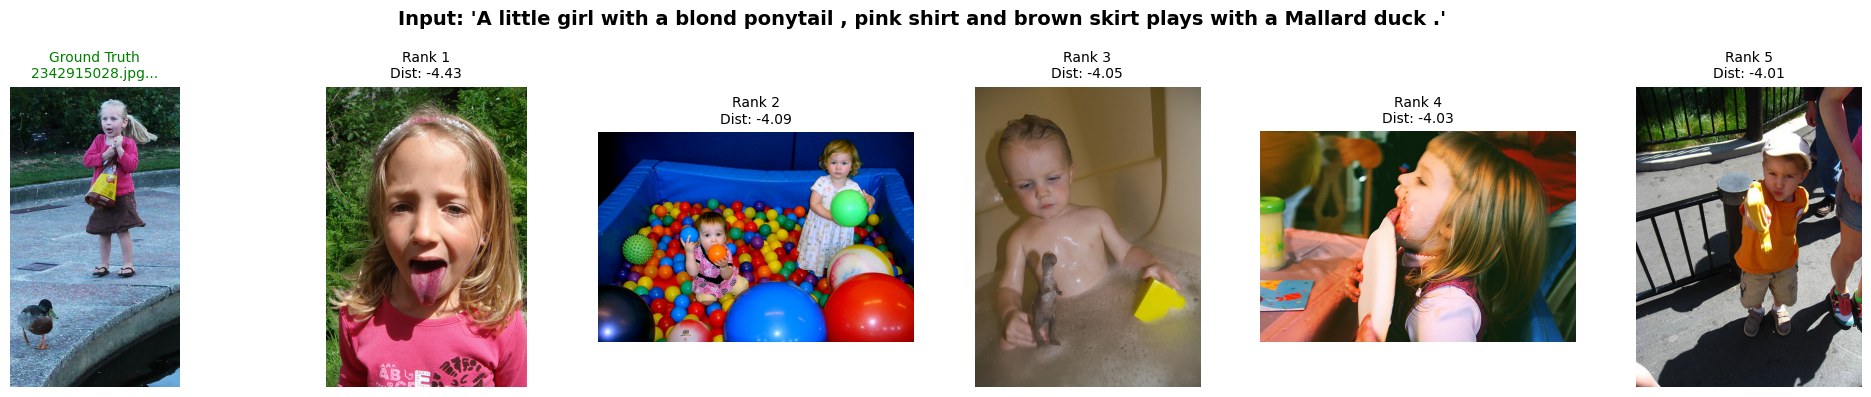

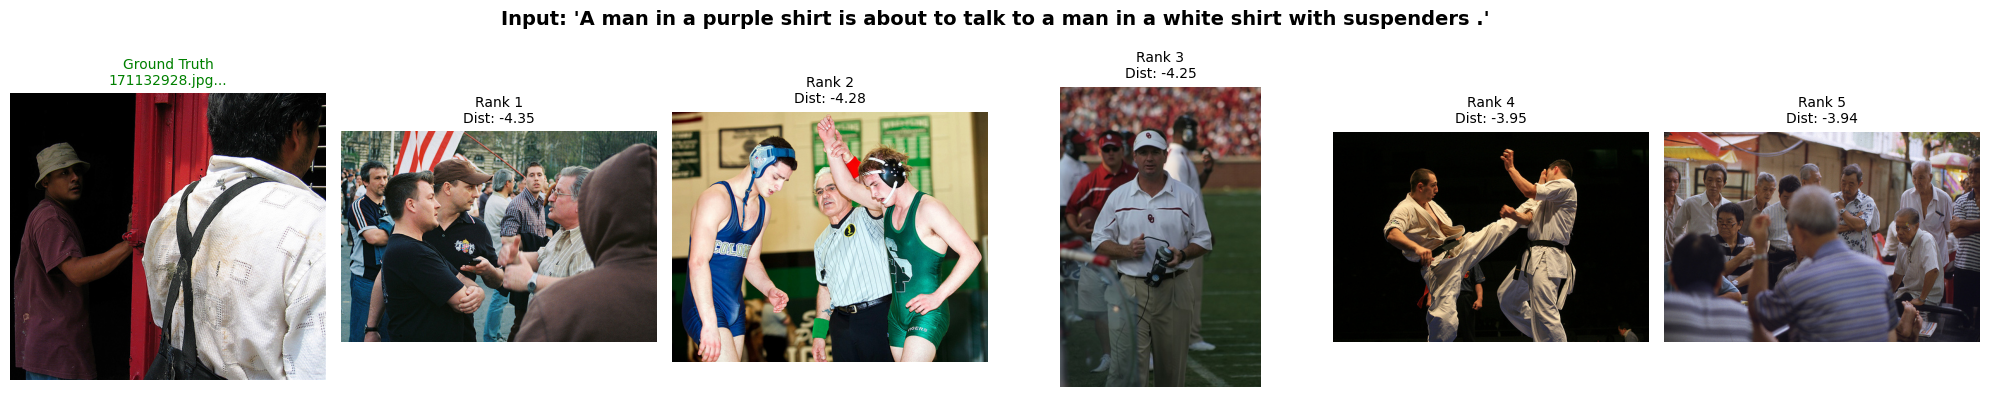

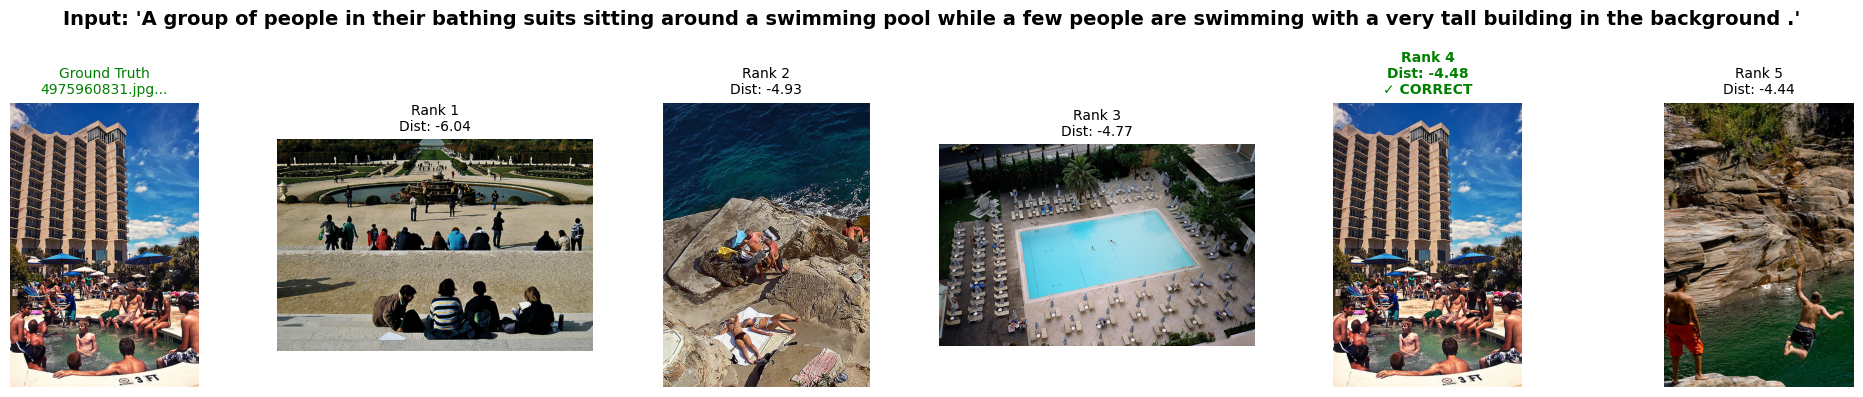

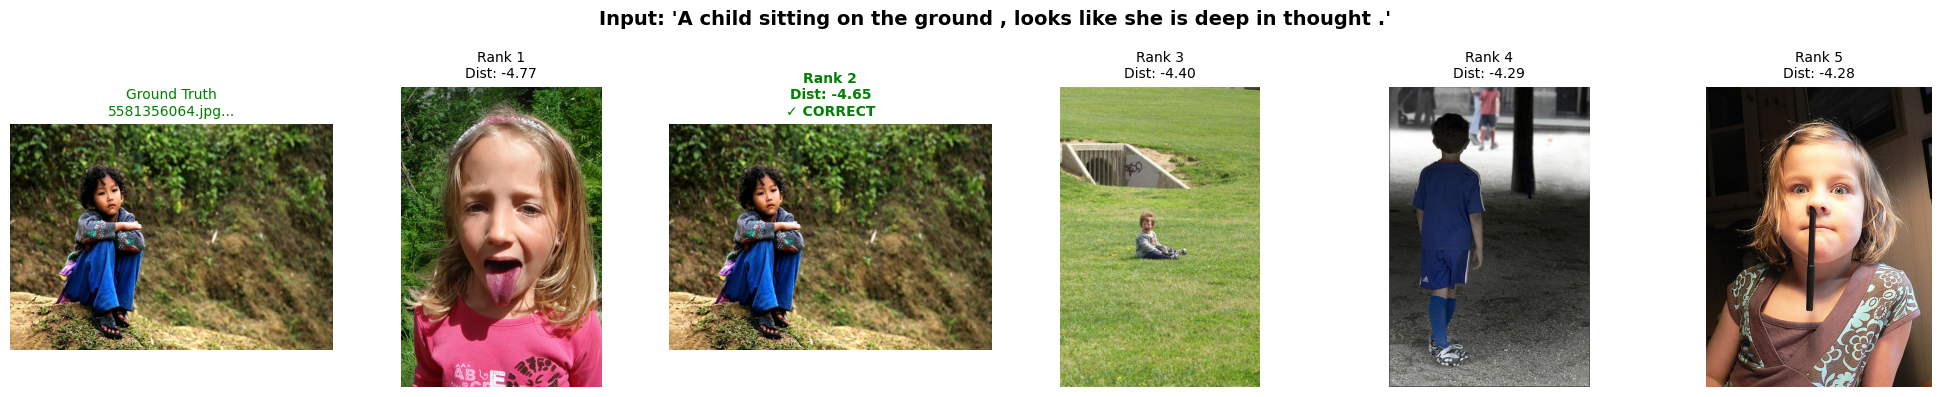

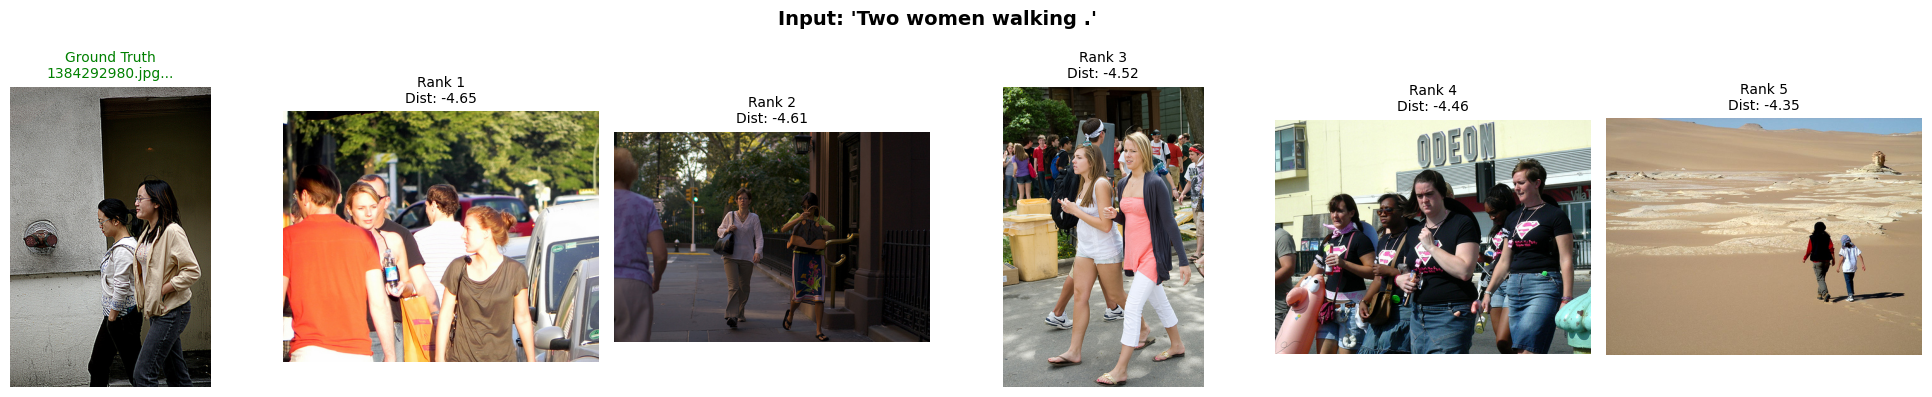

📊 Computing retrieval metrics (Fixed Gallery Size: 100)...
   Text embeddings shape: torch.Size([12500, 1536])
   Image embeddings shape: torch.Size([2500, 1536])
   Fixed gallery size per query: 100 images
   Predicted indices shape: (12500, 100)
   Ground truth indices shape: (12500,)

📊 Validation Metrics (Fixed Gallery Size: 100)
  MRR:       0.8781 (87.81%)
  Recall@1:  0.8095 (80.95%)
  Recall@5:  0.9637 (96.37%)
  Recall@10: 0.9834 (98.34%)
  NDCG@10:   0.9036 (90.36%)
✅ Using fixed gallery size of 100 for dataset-independent metrics
   Each query evaluated against: 1 GT + 99 random negatives
   Total queries evaluated: 12,500



In [22]:
import torch
import numpy as np

print("Preparing validation data...")
# Extract validation subset
val_caption_text = train_data["captions/text"][~TRAIN_SPLIT]
val_text_embd = X_val

# Get the original label matrix for validation
label_matrix = torch.from_numpy(train_data["captions/label"]).bool()

# Get validation images (only those referenced by validation captions)
img_VAL_SPLIT = label_matrix[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data["images/names"][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data["images/embeddings"][img_VAL_SPLIT])

# Map validation captions to their ground truth images
# For evaluation, we take the first matching image for each caption
val_label = np.nonzero(train_data["captions/label"][~TRAIN_SPLIT][:, img_VAL_SPLIT])[1]
print("✅ Validation data prepared")
print(f"   Validation captions: {len(val_text_embd)}")
print(f"   Validation images: {len(val_img_embd)}")
print(f"   Ground truth mappings: {len(val_label)}")

# Visualize random retrieval examples
visualize_random_samples(
    model=best_model,
    val_text_embd=val_text_embd,
    val_caption_text=val_caption_text,
    val_label=val_label,
    val_img_file=val_img_file,
    val_img_embd=val_img_embd,
    device=DEVICE,
    data_dir=DATA_DIR,
    num_samples=5,
)

# Compute full evaluation metrics
metrics_full = compute_and_print_metrics_full_gallery(
    model=best_model,
    val_text_embd=val_text_embd,
    val_label=val_label,
    val_img_embd=val_img_embd,
    device=DEVICE
)

# Generate Final Submission

Load test data and create the final submission file.

In [23]:
# Load test data
test_data = load_data(DATA_DIR + "/test/test.clean.npz")

# Generate submission file
create_submission_file(
    model=best_model,
    test_data=test_data,
    device=DEVICE,
    output_filename="submission_mlp.csv",
    model_path=MODEL_PATH,
)


🔮 Generating predictions for test set...
   Loaded 1,500 test samples
   Test embedding shape: torch.Size([1500, 1024])
✅ Predictions generated: torch.Size([1500, 1536])
Generating submission file...
✓ Saved submission to submission_mlp.csv

💾 Submission file saved: submission_mlp.csv
   Model used: models/mlp/model.pth
   Number of predictions: 1,500

🎉 Ready for Kaggle submission!


id                                          embedding
0        1  [0.017195483669638634, -0.009878681972622871, ...
1        2  [0.007197011727839708, -0.02107481099665165, -...
2        3  [-0.016149571165442467, -0.03343598544597626, ...
3        4  [0.03522801771759987, -0.015345963649451733, -...
4        5  [0.025103630498051643, 0.04239507019519806, 0....
...    ...                                                ...
1495  1496  [-0.0071577937342226505, 0.009798448532819748,...
1496  1497  [0.007256248500198126, 0.020850826054811478, 0...
1497  1498  [0.02780383639037609, -0.003636300563812256, -...
1498  1499  [0.013152539730072021, 0.006501892115920782, 0...
1499  1500  [0.03576686978340149, -0.03258903697133064, -0...

[1500 rows x 2 columns]